### Model

Problem is to find the causal effect of $t$ on $y$ given instruments $z$.

\begin{align*}
y &= \alpha(x) + \beta(x) t + v \\
t &= \kappa(x) + \delta(x) z + u \\
\end{align*}

This gives rise to,
\begin{align*}
y &= \alpha(x) + \beta(x) \kappa(x) + \beta(x) \delta(x) z + v + \beta(x) u \\
y &= \bar{\alpha}(x) + \bar{\beta}(x) z + \bar{v} \\
\end{align*}

We will estimate together,
\begin{align*}
t &= \kappa(x) + \delta(x) z + u \\
y &= \bar{\alpha}(x) + \bar{\beta}(x) z + \bar{v} \\
\end{align*}

For simulation, I specify,
\begin{align*}
x &\sim \mathcal{N}(0, 1) \\
u &\sim \mathcal{N}(0, 1) \\
v &\sim \mathcal{N}(0, 1) \\
z &\sim \mathcal{N}(0, 1) \\
\alpha(x) &= -1 + 0.2 x_1 - 0.3 x_2 - 0.5 x_3 \\
\beta(x) &= 1 - x_2 - 0.25 x_1^3 \\
\kappa(x) &= -1 + 0.5 x_1 + 0.2 x_2 - 0.1 x_3 \\
\delta(x) &= 1 - 0.3 x_1 + 0.4 x_2 \\
\end{align*}



### Data

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n = 10000
d_x = 3
d_z = 1
d_param = 2
x = torch.normal(0, 1, size=(n, d_x)).to(device)
a = -1 + 1 * (0.2 * x[:, 0] - 0.3 * x[:, 1] - 0.5 * x[:, 2])
b = 1 + 1 * (-x[:, 1] - 0.25 * x[:, 0]**3)
c = -1 + 1*(0.5 * x[:, 0] + 0.2 * x[:, 1] - 0.1 * x[:, 2])
d = 1 + 1 *(- 0.3 * x[:, 0] + 0.4 * x[:, 1])
u = torch.normal(0, 1, size=(n,)).to(device)
v = torch.normal(0, 1, size=(n,)).to(device)
z = torch.normal(0, 1, size=(n,)).to(device)
t = c + d * z + u
y = (a + b * c) + (b * d) * z + v + b * u
print(y.shape, t.shape, z.shape, x.shape)

torch.Size([10000]) torch.Size([10000]) torch.Size([10000]) torch.Size([10000, 3])


### Network

In [ ]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self, d_x, arch, d_output=4):
        super(NeuralNetwork, self).__init__()
        layers = []
        layers.append(nn.Linear(d_x, arch[0]))
        layers.append(nn.ReLU())
        for i in range(len(arch) - 1):
            layers.append(nn.Linear(arch[i], arch[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(arch[-1], d_output))
        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

### Two-Network

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

def network1(y, t, z, x, trub=None, trua=None):
    x_train, x_test, y_train, y_test, t_train, t_test, z_train, z_test = train_test_split(x, y, t, z, test_size=0.2)
    d_x = x_train.shape[1]
    n = x_train.shape[0]
    arch = [20, 20, 20]
    model_ab = NeuralNetwork(d_x, arch, d_output = 2).to(device)
    model_cd = NeuralNetwork(d_x, arch, d_output = 2).to(device)
    optimizer = torch.optim.Adam(chain(model_ab.parameters(), model_cd.parameters()), lr=0.0001, weight_decay=0.0000)
    loss_fn = nn.MSELoss(reduction='mean')
    m = 10000
    for i in range(m):
        ab = model_ab(x_train)
        cd = model_cd(x_train)
        alpha = ab[:,0].reshape(n,)
        beta = ab[:,1].reshape(n,)
        kappa = cd[:,0].reshape(n,)
        delta = cd[:,1].reshape(n,)
        t_hat = (kappa + delta * z_train).to(device)
        y_hat = ((alpha + beta * kappa) + (beta * delta) * z_train).to(device)
        loss = loss_fn(t_hat, t_train) + loss_fn(y_hat, y_train)
        l2_lambda = 0.0001
        l2_reg = torch.tensor(0.).to(device)
        for param in model_ab.parameters():
            l2_reg += torch.norm(param)
        for param in model_cd.parameters():
            l2_reg += torch.norm(param)
        loss += l2_lambda * l2_reg
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % (m/10) == 0:
            with torch.no_grad():
                ab = model_ab(x_test)
                cd = model_cd(x_test)
                alpha = ab[:,0].reshape(-1,)
                beta = ab[:,1].reshape(-1,)
                kappa = cd[:,0].reshape(-1,)
                delta = cd[:,1].reshape(-1,)
                t_hat_test = (kappa + delta * z_test).to(device)
                y_hat_test = ((alpha + beta * kappa) + (beta * delta) * z_test).to(device)
                r2_t = r2_score(t_test.cpu(), t_hat_test.cpu())
                r2_y = r2_score(y_test.cpu(), y_hat_test.cpu())
            print(f"Loss: {loss.item()}, (Test) R2 T: {r2_t}, (Test) R2 Y: {r2_y}")
    # Plot
    print('\nPlotting Params and Preds\n')
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    sns.kdeplot(alpha.cpu().detach().numpy(), ax=axs[0, 0], label='Alpha Est', linestyle="--")
    if trua is not None:
        sns.kdeplot(a.cpu().detach().numpy(), ax=axs[0, 0], label='Alpha True')
    axs[0, 0].legend()
    sns.kdeplot(beta.cpu().detach().numpy(), ax=axs[0, 1], label='Beta Est', linestyle="--")
    if trub is not None:
        sns.kdeplot(b.cpu().detach().numpy(), ax=axs[0, 1], label='Beta True')
    axs[0, 1].legend()
    sns.kdeplot(y_hat_test.cpu().detach().numpy(), ax=axs[1, 0], label='Y_hat Est', linestyle="--")
    sns.kdeplot(y_test.cpu().detach().numpy(), ax=axs[1, 0], label='True')
    axs[1, 0].legend()
    sns.kdeplot(t_hat_test.cpu().detach().numpy(), ax=axs[1, 1], label='T_hat Est', linestyle="--")
    sns.kdeplot(t_test.cpu().detach().numpy(), ax=axs[1, 1], label='True')
    axs[1, 1].legend()
    plt.show()
    return model_ab, model_cd, y_hat, t_hat

def network2(y, t, z, x, trub=None, trua=None):
    x_train, x_test, y_train, y_test, t_train, t_test, z_train, z_test = train_test_split(x, y, t, z, test_size=0.2)
    d_x = x_train.shape[1]
    n = x_train.shape[0]
    z_train = z_train.reshape(n,-1)
    d_z = z_train.shape[1]
    arch = [20, 20, 20]
    model_ab = NeuralNetwork(d_x, arch, d_output = 2).to(device)
    model_cd = NeuralNetwork(d_x + d_z, arch, d_output = 1).to(device)
    optimizer = torch.optim.Adam(chain(model_ab.parameters(), model_cd.parameters()), lr=0.0001, weight_decay=0.000)
    loss_fn = nn.MSELoss(reduction='mean')
    m = 10000
    for i in range(m):
        ab = model_ab(x_train)
        alpha = ab[:,0].reshape(n,)
        beta = ab[:,1].reshape(n,)
        t_hat = model_cd(torch.cat((x_train,z_train), dim=1)).reshape(-1).to(device)
        y_hat = (alpha + beta * t_hat).to(device)
        loss = loss_fn(t_hat, t_train) + loss_fn(y_hat, y_train)

        # regularization
        l2_lambda = 0.00001
        l2_reg = torch.tensor(0.).to(device)
        for param in model_ab.parameters():
            l2_reg += torch.norm(param)
        for param in model_cd.parameters():
            l2_reg += torch.norm(param)
        loss += l2_lambda * l2_reg

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % (m/10) == 0:
            with torch.no_grad():
                ab = model_ab(x_test)
                alpha = ab[:,0].reshape(-1,)
                beta = ab[:,1].reshape(-1,)
                t_hat_test = model_cd(torch.cat((x_test, z_test), dim=1)).reshape(-1).to(device)
                y_hat_test = (alpha + beta * t_hat_test).to(device)
                r2_t = r2_score(t_test.cpu(), t_hat_test.cpu())
                r2_y = r2_score(y_test.cpu(), y_hat_test.cpu())
            print(f"Loss: {loss.item()}, (Test) R2 T: {r2_t}, (Test) R2 Y: {r2_y}")
    # Plot
    print('\nPlotting Params and Preds\n')
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    sns.kdeplot(alpha.cpu().detach().numpy(), ax=axs[0, 0], label='Alpha Est', linestyle="--")
    if trua is not None:
        sns.kdeplot(a.cpu().detach().numpy(), ax=axs[0, 0], label='Alpha True')
    axs[0, 0].legend()
    sns.kdeplot(beta.cpu().detach().numpy(), ax=axs[0, 1], label='Beta Est', linestyle="--")
    if trub is not None:
        sns.kdeplot(b.cpu().detach().numpy(), ax=axs[0, 1], label='Beta True')
    axs[0, 1].legend()
    sns.kdeplot(y_hat_test.cpu().detach().numpy(), ax=axs[1, 0], label='Y_hat Est', linestyle="--")
    sns.kdeplot(y_test.cpu().detach().numpy(), ax=axs[1, 0], label='True')
    axs[1, 0].legend()
    sns.kdeplot(t_hat_test.cpu().detach().numpy(), ax=axs[1, 1], label='T_hat Est', linestyle="--")
    sns.kdeplot(t_test.cpu().detach().numpy(), ax=axs[1, 1], label='True')
    axs[1, 1].legend()
    plt.show()
    return model_ab, model_cd, y_hat, t_hat

Check Params

Loss: 24.13714027404785, (Test) R2 T: -0.5983427893170097, (Test) R2 Y: -0.6033041378948205
Loss: 6.775387763977051, (Test) R2 T: 0.4595584389210742, (Test) R2 Y: 0.5879338504415286
Loss: 5.561999320983887, (Test) R2 T: 0.5727190202195402, (Test) R2 Y: 0.6392645951992033
Loss: 5.122129440307617, (Test) R2 T: 0.5797631711651859, (Test) R2 Y: 0.6532573432204174
Loss: 4.894809246063232, (Test) R2 T: 0.5817380940976007, (Test) R2 Y: 0.6568682746336842
Loss: 4.6862874031066895, (Test) R2 T: 0.5852301763579169, (Test) R2 Y: 0.6605355351061979
Loss: 4.556915760040283, (Test) R2 T: 0.5831560292199571, (Test) R2 Y: 0.654262015605914
Loss: 4.436898231506348, (Test) R2 T: 0.5789404559466789, (Test) R2 Y: 0.6459925669799812
Loss: 4.315101146697998, (Test) R2 T: 0.5704109293933725, (Test) R2 Y: 0.6388022018734558
Loss: 4.216701030731201, (Test) R2 T: 0.565132940758909, (Test) R2 Y: 0.6356854054980556

Plotting Params and Preds



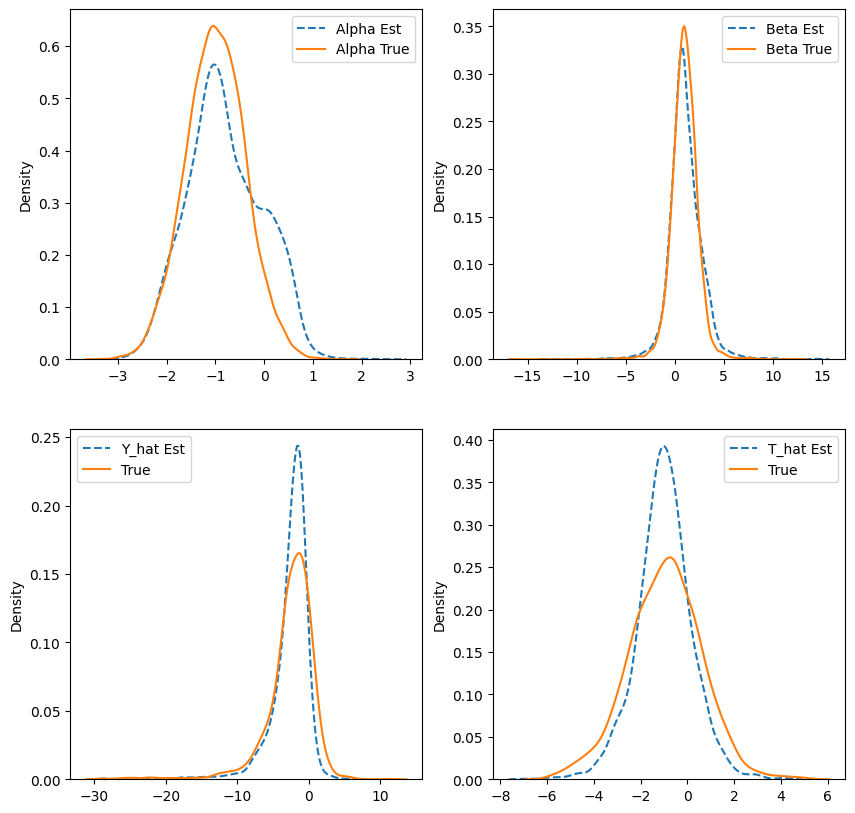

In [ ]:
model_ab, model_cd, y_hat, t_hat = network1(y, t, z, x, b, a)

Loss: 21.98052978515625, (Test) R2 T: -0.33207767589719683, (Test) R2 Y: -0.5386298628680244
Loss: 7.070563316345215, (Test) R2 T: 0.5208346951756284, (Test) R2 Y: 0.5719088359862188
Loss: 5.648705005645752, (Test) R2 T: 0.581298392301052, (Test) R2 Y: 0.6218228717726937
Loss: 5.062750339508057, (Test) R2 T: 0.5907586907066069, (Test) R2 Y: 0.6429322986557443
Loss: 4.8271002769470215, (Test) R2 T: 0.5906883688252011, (Test) R2 Y: 0.6480524205670354
Loss: 4.699192523956299, (Test) R2 T: 0.5936402805299305, (Test) R2 Y: 0.6489839496089355
Loss: 4.591301918029785, (Test) R2 T: 0.5945428901803937, (Test) R2 Y: 0.6482753382395061
Loss: 4.491472244262695, (Test) R2 T: 0.5945167936507327, (Test) R2 Y: 0.6480550863354776
Loss: 4.386852741241455, (Test) R2 T: 0.5933970722057511, (Test) R2 Y: 0.6487015825179161
Loss: 4.297427654266357, (Test) R2 T: 0.5907550106188706, (Test) R2 Y: 0.6457291660361267

Plotting Params and Preds



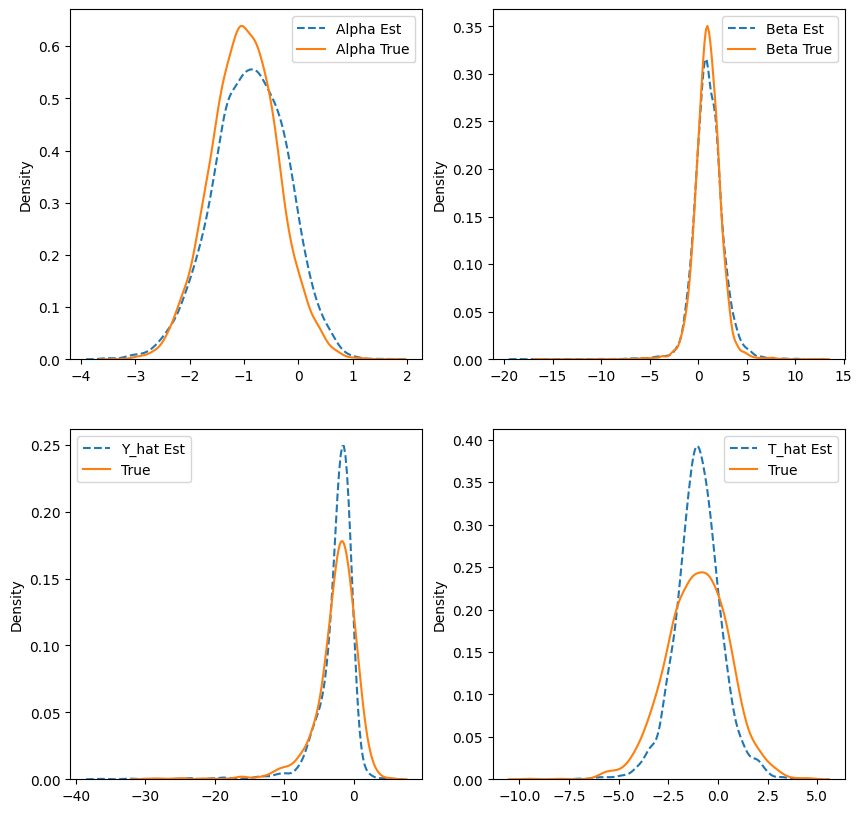

In [ ]:
model_ab, model_cd, y_hat, t_hat = network2(y, t, z.reshape(x.shape[0],1), x, b, a)

tensor(1.0760, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0138, device='cuda:0')
tensor(-0.8887, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.9965, device='cuda:0')


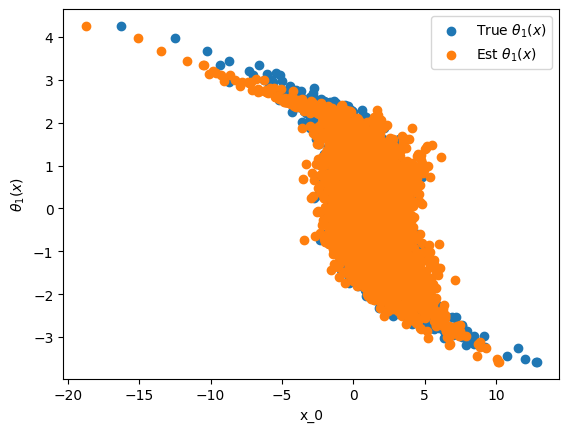

In [ ]:
ab = model_ab(x)
beta = ab[:,1].reshape(n,)
alpha = ab[:,0].reshape(n,)
print(torch.mean(beta))
print(torch.mean(b))
print(torch.mean(alpha))
print(torch.mean(a))
plt.scatter(b.cpu().detach().numpy(), x[:,0].cpu().detach().numpy(), label = f'True $\\theta_1(x)$')
plt.scatter(beta.cpu().detach().numpy(), x[:,0].cpu().detach().numpy(), label = f'Est $\\theta_1(x)$')
plt.xlabel('x_0')
plt.ylabel(f'$\\theta_1(x)$')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
y_np = y.cpu().detach().numpy()
t_np = t.cpu().detach().numpy()
x_np = x.cpu().detach().numpy()
z_np = z.reshape(x.shape[0],1).cpu().detach().numpy()
df = pd.DataFrame({'outcome': y_np,'treatment': t_np})
for i in range(x_np.shape[1]):
    df[f'cov_{i}'] = x_np[:, i]
for i in range(z_np.shape[1]):
    df[f'instr_{i}'] = z_np[:, i]
outcome = 'outcome'
treatment = 'treatment'
covariates = [f'cov_{i}' for i in range(x_np.shape[1])]
instruments = [f'instr_{i}' for i in range(z_np.shape[1])]
endog = df[outcome]
exog = df[[treatment] + covariates]
instr = df[covariates + instruments]
exog_constant = sm.add_constant(exog)
instr_constant = sm.add_constant(instr)
IV2SLS_model = IV2SLS(endog, exog_constant, instrument=instr_constant).fit()
print(IV2SLS_model.summary())

                          IV2SLS Regression Results                           
Dep. Variable:                outcome   R-squared:                       0.359
Model:                         IV2SLS   Adj. R-squared:                  0.359
Method:                     Two Stage   F-statistic:                     1115.
                        Least Squares   Prob (F-statistic):               0.00
Date:                Wed, 24 Jan 2024                                         
Time:                        05:41:23                                         
No. Observations:               10000                                         
Df Residuals:                    9995                                         
Df Model:                           4                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7544      0.040    -44.108      0.0

### Returns to Education

In [ ]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
df = pd.read_csv('wage2.csv')
cat = df.select_dtypes('object').columns
df = pd.get_dummies(df, columns=cat, drop_first=True)
df = df.dropna()
outcome = 'lwage'
treatment = 'educ'
covariates = ['IQ', 'KWW', 'exper', 'tenure', 'age', 'married', 'black', 'south', 'urban']
instruments = ['sibs', 'brthord', 'meduc', 'feduc']
df = df[[outcome, treatment] + covariates + instruments]
scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
y = torch.tensor(df_normalized[outcome].values, dtype=torch.float32).to(device)
t = torch.tensor(df_normalized[treatment].values, dtype=torch.float32).to(device)
x = torch.tensor(df_normalized[covariates].values, dtype=torch.float32).to(device)
z = torch.tensor(df_normalized[instruments].values, dtype=torch.float32).to(device)
print(y.shape, t.shape, x.shape, z.shape)

torch.Size([663]) torch.Size([663]) torch.Size([663, 9]) torch.Size([663, 4])


Loss: 2.091277599334717, (Test) R2 T: 0.0035074608666625373, (Test) R2 Y: -0.00435526036765066
Loss: 1.0906025171279907, (Test) R2 T: 0.6244991562107034, (Test) R2 Y: 0.2515462624705932
Loss: 0.7503437399864197, (Test) R2 T: 0.6015001318654583, (Test) R2 Y: 8.225126681971062e-07
Loss: 0.47958487272262573, (Test) R2 T: 0.5779553699009212, (Test) R2 Y: -0.31746306583356354
Loss: 0.3359907269477844, (Test) R2 T: 0.48957328712420645, (Test) R2 Y: -0.6901837783232685
Loss: 0.2525341212749481, (Test) R2 T: 0.39994884287380317, (Test) R2 Y: -1.1507602329799167
Loss: 0.18824277818202972, (Test) R2 T: 0.30250664585262055, (Test) R2 Y: -1.7364019871950105
Loss: 0.14287182688713074, (Test) R2 T: 0.1818793190998388, (Test) R2 Y: -2.6521240681189435
Loss: 0.10583695024251938, (Test) R2 T: 0.1067377687619967, (Test) R2 Y: -3.486655272945768
Loss: 0.08135794848203659, (Test) R2 T: 0.051584497609636126, (Test) R2 Y: -4.021942885324479

Plotting Params and Preds



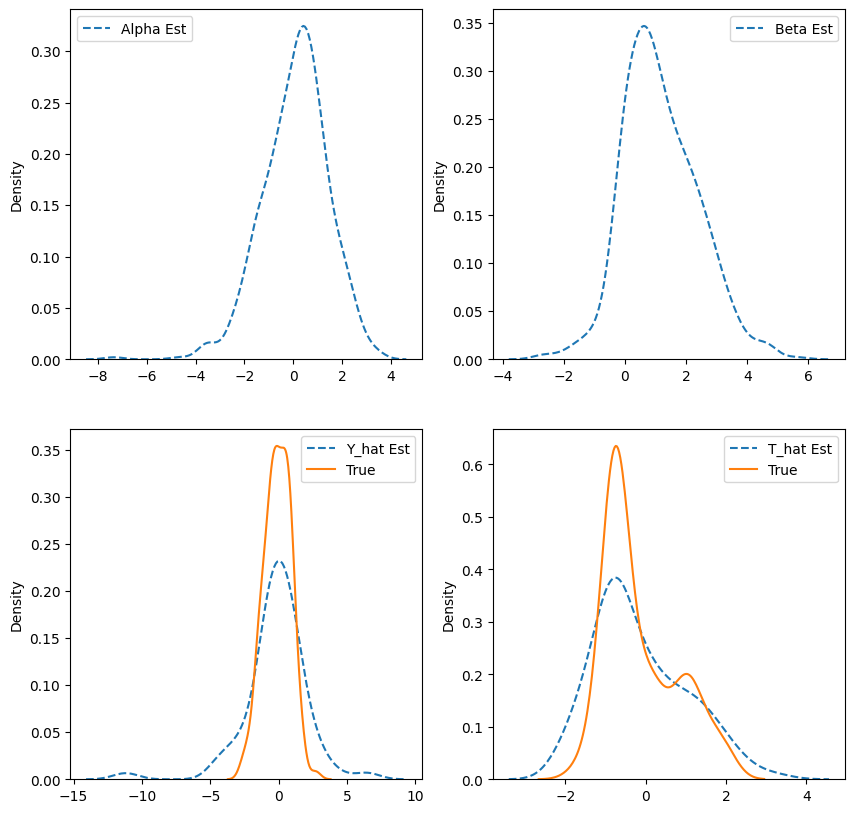

In [ ]:
model_ab, model_cd, y_hat, t_hat = network2(y, t, z, x)

tensor(1.3853, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2676, device='cuda:0', grad_fn=<MeanBackward0>)


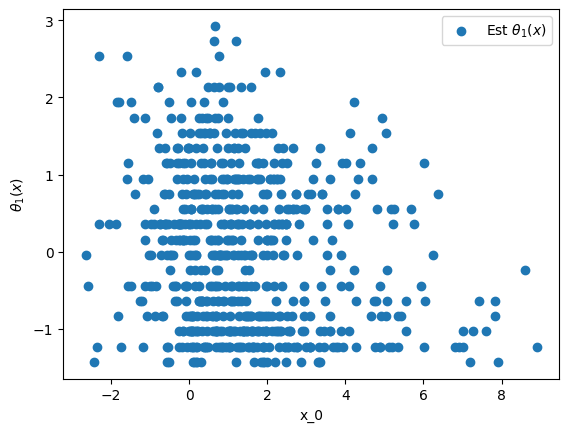

In [ ]:
ab = model_ab(x)
n = x.shape[0]
beta = ab[:,1].reshape(n,)
alpha = ab[:,0].reshape(n,)
print(torch.mean(beta))
print(torch.mean(alpha))
plt.scatter(beta.cpu().detach().numpy(), x[:,3].cpu().detach().numpy(), label = f'Est $\\theta_1(x)$')
plt.xlabel('x_0')
plt.ylabel(f'$\\theta_1(x)$')
plt.legend()
plt.show()

In [ ]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
endog = df[outcome]
exog =  df[[treatment] + covariates]
instr = df[covariates + instruments]
exog_constant = sm.add_constant(exog)
instr_constant = sm.add_constant(instr)
IV2SLS = IV2SLS(endog, exog_constant, instrument = instr_constant).fit()
print(IV2SLS.summary())

                          IV2SLS Regression Results                           
Dep. Variable:                  lwage   R-squared:                       0.181
Model:                         IV2SLS   Adj. R-squared:                  0.169
Method:                     Two Stage   F-statistic:                     20.15
                        Least Squares   Prob (F-statistic):           1.19e-32
Date:                Wed, 24 Jan 2024                                         
Time:                        05:45:44                                         
No. Observations:                 663                                         
Df Residuals:                     652                                         
Df Model:                          10                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6647      0.246     18.939      0.0

### MARKET DEMAND FOR AUTOMOBILES

In [ ]:
def construct_iv(blp_data, x_cols):
    n = blp_data.shape[0]
    p = len(x_cols)

    firmid = blp_data['firm.id'].values
    cdid = blp_data['cdid'].values
    id_var = blp_data['id'].values
    X = blp_data[x_cols]

    sum_other = pd.DataFrame(columns=['sum.other.' + var for var in x_cols], index=blp_data.index)
    sum_rival = pd.DataFrame(columns=['sum.rival.' + var for var in x_cols], index=blp_data.index)

    for i in range(n):
        other_ind = (firmid == firmid[i]) & (cdid == cdid[i]) & (id_var != id_var[i])
        rival_ind = (firmid != firmid[i]) & (cdid == cdid[i])
        for j in range(p):
            sum_other.iloc[i, j] = X.iloc[:, j][other_ind].sum()
            sum_rival.iloc[i, j] = X.iloc[:, j][rival_ind].sum()

    return pd.concat((sum_other, sum_rival), axis=1)

blp_data.columns = blp_data.columns.str.replace('BLP.', '')
x_cols = ['hpwt', 'air', 'mpd', 'space']
iv_vars = construct_iv(blp_data, x_cols)
blp_data['log_price'] = np.log(blp_data['price'] + 11.761)
y_col = 'y'
d_col = 'log_price'
cluster_cols = ['model.id', 'cdid']
all_z_cols = ['sum.other.hpwt', 'sum.other.mpd', 'sum.other.space']
df = pd.concat((blp_data[[y_col, d_col] + cluster_cols + x_cols], iv_vars[all_z_cols]), axis=1)
df['sum.other.hpwt'] = df['sum.other.hpwt'].astype(float)
df['sum.other.mpd'] = df['sum.other.mpd'].astype(float)
df['sum.other.space'] = df['sum.other.space'].astype(float)
df.shape

<ipython-input-98-c5c9dfe1302c>:22: FutureWarning: The default value of regex will change from True to False in a future version.
  blp_data.columns = blp_data.columns.str.replace('BLP.', '')


(2217, 11)

In [ ]:
from statsmodels.sandbox.regression.gmm import IV2SLS
outcome = 'y'
treatment = 'log_price'
covariates = ['hpwt', 'air', 'space']
instruments = ['sum.other.hpwt', 'sum.other.mpd', 'sum.other.space']
endog = df[outcome]
exog = df[[treatment] + covariates]
instr = df[covariates + instruments]
exog_constant = sm.add_constant(exog)
instr_constant = sm.add_constant(instr)
IV2SLS_model = IV2SLS(endog, exog_constant, instrument=instr_constant).fit()
print(IV2SLS_model.summary())

                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                      -0.185
Model:                         IV2SLS   Adj. R-squared:                 -0.188
Method:                     Two Stage   F-statistic:                     155.9
                        Least Squares   Prob (F-statistic):          1.23e-117
Date:                Wed, 24 Jan 2024                                         
Time:                        06:39:34                                         
No. Observations:                2217                                         
Df Residuals:                    2212                                         
Df Model:                           4                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4177      0.425     10.404      0.0

Loss: 2.036973476409912, (Test) R2 T: -0.0026075656811470616, (Test) R2 Y: -0.01690810536426901
Loss: 0.90181964635849, (Test) R2 T: 0.715346380159114, (Test) R2 Y: 0.38046492792968556
Loss: 0.7411413192749023, (Test) R2 T: 0.7710363196370231, (Test) R2 Y: 0.45219098420066284
Loss: 0.653820276260376, (Test) R2 T: 0.7879322888920967, (Test) R2 Y: 0.48055364498660713
Loss: 0.5873627066612244, (Test) R2 T: 0.7940545651871443, (Test) R2 Y: 0.4858480193643244
Loss: 0.5482730269432068, (Test) R2 T: 0.7956240539749854, (Test) R2 Y: 0.4773833510480914
Loss: 0.52027428150177, (Test) R2 T: 0.7984358829710377, (Test) R2 Y: 0.47334643840693713
Loss: 0.5010831952095032, (Test) R2 T: 0.8004624366627391, (Test) R2 Y: 0.4614721082889356
Loss: 0.48660242557525635, (Test) R2 T: 0.8017036189306994, (Test) R2 Y: 0.451014666965061
Loss: 0.4752100706100464, (Test) R2 T: 0.8024554711512626, (Test) R2 Y: 0.4473153570497759

Plotting Params and Preds



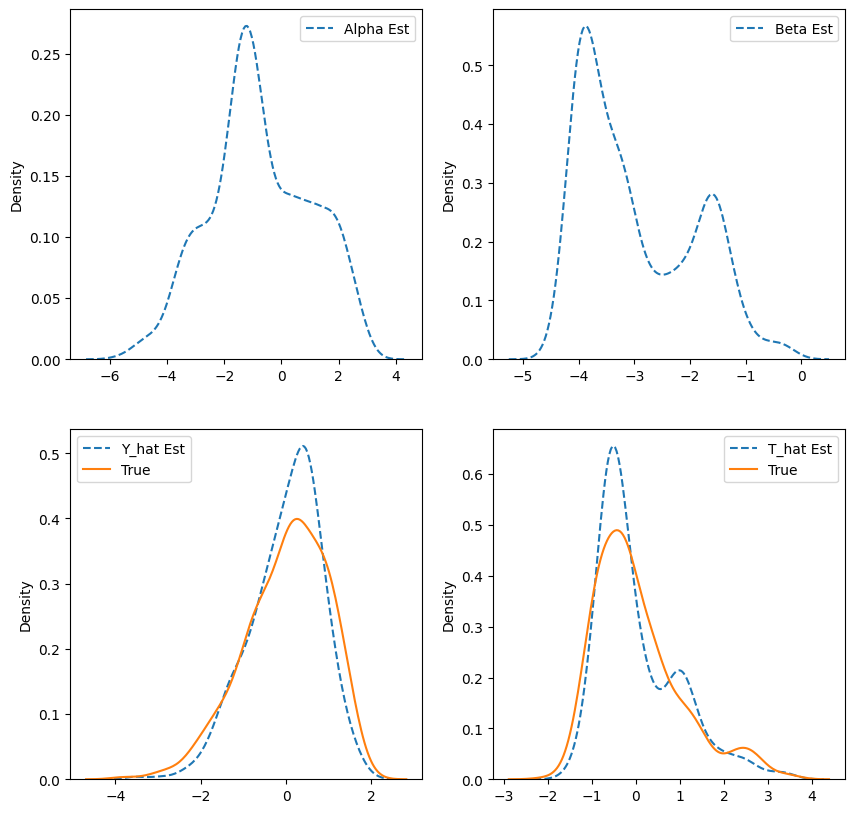

In [ ]:
df = df[[outcome, treatment] + covariates + instruments]
scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
y = torch.tensor(df_normalized[outcome].values, dtype=torch.float32).to(device)
t = torch.tensor(df_normalized[treatment].values, dtype=torch.float32).to(device)
x = torch.tensor(df_normalized[covariates].values, dtype=torch.float32).to(device)
z = torch.tensor(df_normalized[instruments].values, dtype=torch.float32).to(device)
model_ab, model_cd, y_hat, t_hat = network2(y, t, z, x)

tensor(-2.9622, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.7326, device='cuda:0', grad_fn=<MeanBackward0>)


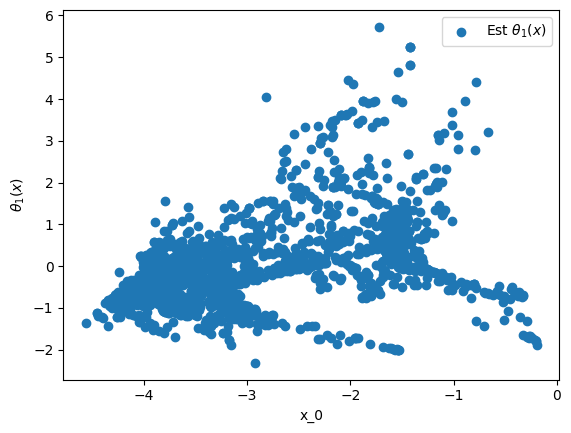

In [ ]:
ab = model_ab(x)
n = x.shape[0]
beta = ab[:,1].reshape(n,)
alpha = ab[:,0].reshape(n,)
print(torch.mean(beta))
print(torch.mean(alpha))
plt.scatter(beta.cpu().detach().numpy(), x[:,0].cpu().detach().numpy(), label = f'Est $\\theta_1(x)$')
plt.xlabel('x_0')
plt.ylabel(f'$\\theta_1(x)$')
plt.legend()
plt.show()

### MARKET DEMAND FOR CEREAL

In [ ]:
from statsmodels.sandbox.regression.gmm import IV2SLS
import statsmodels.api as sm
outcome = 'shares'
treatment = 'prices'
covariates = ['sugar', 'mushy']
instruments = []
for i in range(19):
    name = 'demand_instruments' + str(i)
    instruments.append(name)
df = pd.read_csv(pyblp.data.NEVO_PRODUCTS_LOCATION)
#temp = pd.get_dummies(df.product_ids, drop_first = True)
#ids = list(temp.columns)
#rest = rest + ids
#df = pd.concat([df,temp], axis = 1)
df.shares = np.log(df.shares)
df.prices = np.log(df.prices)
endog = df[outcome]
exog =  df[[treatment] + covariates]
instr = df[covariates + instruments]
exog_constant = sm.add_constant(exog)
instr_constant = sm.add_constant(instr)
IV2SLS = IV2SLS(endog, exog_constant, instrument = instr_constant).fit()
print(IV2SLS.summary())

                          IV2SLS Regression Results                           
Dep. Variable:                 shares   R-squared:                       0.084
Model:                         IV2SLS   Adj. R-squared:                  0.083
Method:                     Two Stage   F-statistic:                     71.17
                        Least Squares   Prob (F-statistic):           5.69e-44
Date:                Wed, 24 Jan 2024                                         
Time:                        06:49:18                                         
No. Observations:                2256                                         
Df Residuals:                    2252                                         
Df Model:                           3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.5919      0.233    -32.562      0.0

In [ ]:
scaler = StandardScaler()
df = df[[outcome, treatment] + covariates + instruments]
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
y = torch.tensor(df_normalized[outcome].values, dtype=torch.float32).to(device)
t = torch.tensor(df_normalized[treatment].values, dtype=torch.float32).to(device)
x = torch.tensor(df_normalized[covariates].values, dtype=torch.float32).to(device)
z = torch.tensor(df_normalized[instruments].values, dtype=torch.float32).to(device)
model_ab, model_cd, y_hat, t_hat = network2(y, t, z, x)

torch.Size([2256]) torch.Size([2256]) torch.Size([2256, 2]) torch.Size([2256, 19])


Loss: 2.0125908851623535, (Test) R2 T: 0.007789010081192593, (Test) R2 Y: -0.007058504539277921
Loss: 0.9025154709815979, (Test) R2 T: 0.9160110570818163, (Test) R2 Y: 0.1517681026579727
Loss: 0.7900575399398804, (Test) R2 T: 0.937717891920483, (Test) R2 Y: 0.2163760688623675
Loss: 0.7242137789726257, (Test) R2 T: 0.9363491981067277, (Test) R2 Y: 0.27138887026453207
Loss: 0.6519822478294373, (Test) R2 T: 0.9281278873044713, (Test) R2 Y: 0.3296906401866354
Loss: 0.5936469435691833, (Test) R2 T: 0.914739795618821, (Test) R2 Y: 0.3556572601003831
Loss: 0.5528252124786377, (Test) R2 T: 0.887064946222245, (Test) R2 Y: 0.34030507806139054
Loss: 0.5297279357910156, (Test) R2 T: 0.8690918667853524, (Test) R2 Y: 0.31061435924406255
Loss: 0.5159002542495728, (Test) R2 T: 0.8581265016951045, (Test) R2 Y: 0.2954449680383605
Loss: 0.5071840882301331, (Test) R2 T: 0.8482941813406535, (Test) R2 Y: 0.28236948645359505

Plotting Params and Preds



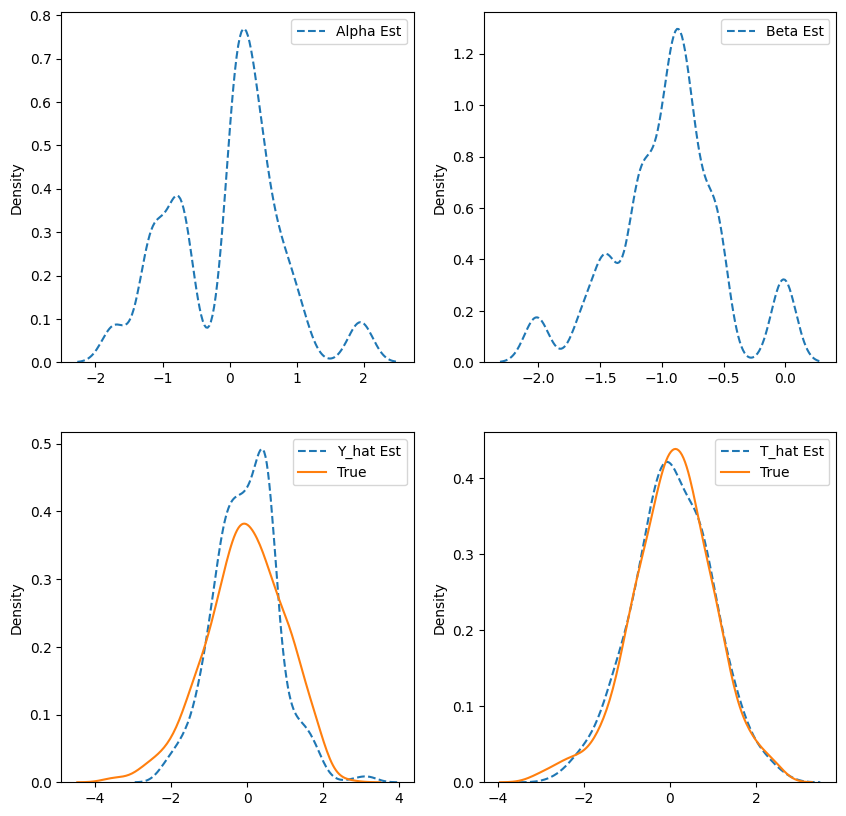

In [ ]:
model_ab, model_cd, y_hat, t_hat = network2(y, t, z, x)

tensor(1.2169, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0930, device='cuda:0', grad_fn=<MeanBackward0>)


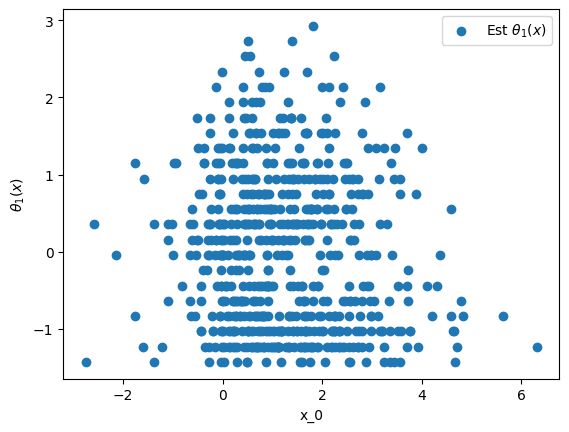

In [ ]:
ab = model_ab(x)
n = x.shape[0]
beta = ab[:,1].reshape(n,)
alpha = ab[:,0].reshape(n,)
print(torch.mean(beta))
print(torch.mean(alpha))
plt.scatter(beta.cpu().detach().numpy(), x[:,3].cpu().detach().numpy(), label = f'Est $\\theta_1(x)$')
plt.xlabel('x_0')
plt.ylabel(f'$\\theta_1(x)$')
plt.legend()
plt.show()

### A/B Test

In [ ]:
# Import the sample AB data
file_url = "https://msalicedatapublic.z5.web.core.windows.net/datasets/RecommendationAB/ab_sample.csv"
df = pd.read_csv(file_url)
Z = ab_data['easier_signup'] # nudge, or instrument
T = ab_data['became_member'] # intervention, or treatment
Y = ab_data['days_visited_post'] # outcome of interest
X_data = ab_data.drop(columns=['easier_signup', 'became_member', 'days_visited_post']) # features
d
# Define underlying treatment effect function
TE_fn = lambda X: (0.2 + 0.3 * X['days_visited_free_pre'] - 0.2 * X['days_visited_hs_pre'] + X['os_type_osx']).values
true_TE = TE_fn(X_data)

# Define the true coefficients to compare with
true_coefs = np.zeros(X_data.shape[1])
true_coefs[[1, 3, -2]] = [0.3, -0.2, 1]

In [ ]:
file_url = "https://msalicedatapublic.z5.web.core.windows.net/datasets/RecommendationAB/ab_sample.csv"
df = pd.read_csv(file_url)
outcome = 'days_visited_post'
treatment = 'became_member'
instruments = ['easier_signup']
covariates = ['days_visited_exp_pre', 'days_visited_free_pre', 'days_visited_fs_pre','days_visited_hs_pre', 'days_visited_rs_pre', 'days_visited_vrs_pre','locale_en_US', 'revenue_pre', 'os_type_osx', 'os_type_windows']
endog = df[outcome]
exog =  df[[treatment] + covariates]
instr = df[covariates + instruments]
exog_constant = sm.add_constant(exog)
instr_constant = sm.add_constant(instr)
IV2SLS = IV2SLS(endog, exog_constant, instrument = instr_constant).fit()
print(IV2SLS.summary())

                          IV2SLS Regression Results                           
Dep. Variable:      days_visited_post   R-squared:                       0.448
Model:                         IV2SLS   Adj. R-squared:                  0.448
Method:                     Two Stage   F-statistic:                     6928.
                        Least Squares   Prob (F-statistic):               0.00
Date:                Wed, 24 Jan 2024                                         
Time:                        07:17:30                                         
No. Observations:              100000                                         
Df Residuals:                   99988                                         
Df Model:                          11                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.73

Loss: 2.027601480484009, (Test) R2 T: 0.004366712033851861, (Test) R2 Y: -0.03242994323051751
Loss: 1.0136624574661255, (Test) R2 T: 0.552099424327968, (Test) R2 Y: 0.4299518906291988
Loss: 1.0024951696395874, (Test) R2 T: 0.5553732075282787, (Test) R2 Y: 0.4349703633817604
Loss: 0.9990248680114746, (Test) R2 T: 0.5555334294532901, (Test) R2 Y: 0.43577459977396893
Loss: 0.9972127079963684, (Test) R2 T: 0.5554705759206449, (Test) R2 Y: 0.4361852061950322
Loss: 0.9956769347190857, (Test) R2 T: 0.5549638607790637, (Test) R2 Y: 0.4361638042059507
Loss: 0.9942049384117126, (Test) R2 T: 0.5545901254985155, (Test) R2 Y: 0.43593646973433464
Loss: 0.9926759004592896, (Test) R2 T: 0.5540888920849287, (Test) R2 Y: 0.4352595842747846
Loss: 0.9910248517990112, (Test) R2 T: 0.5534206399036397, (Test) R2 Y: 0.43461386417158576
Loss: 0.9894775748252869, (Test) R2 T: 0.5527853741624343, (Test) R2 Y: 0.4337458098615842

Plotting Params and Preds



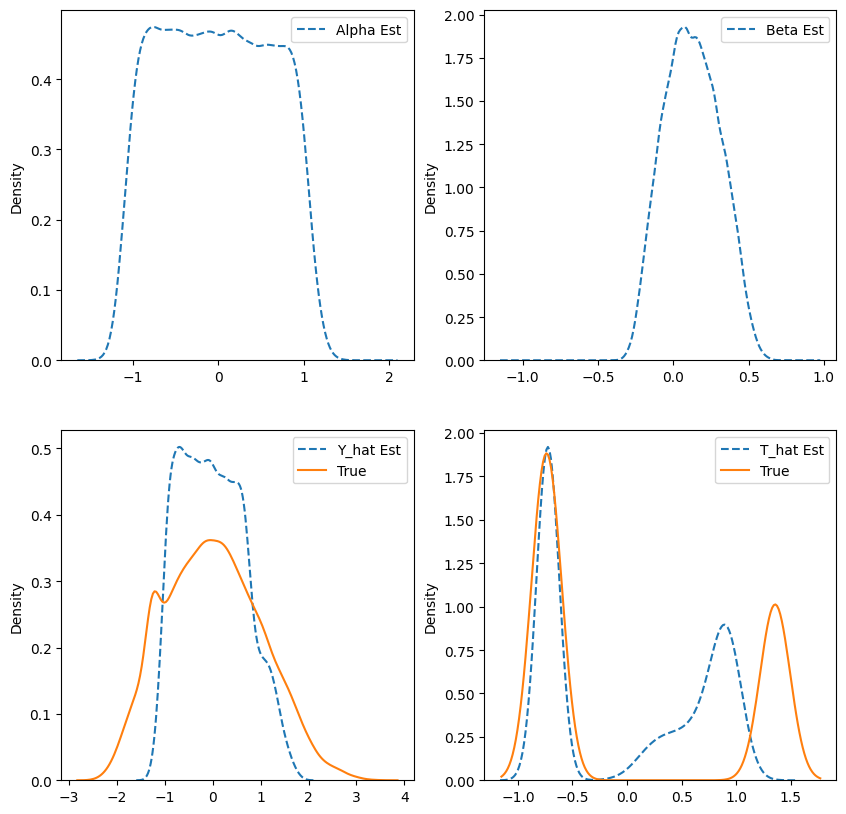

In [ ]:
scaler = StandardScaler()
df = df[[outcome, treatment] + covariates + instruments]
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
y = torch.tensor(df_normalized[outcome].values, dtype=torch.float32).to(device)
t = torch.tensor(df_normalized[treatment].values, dtype=torch.float32).to(device)
x = torch.tensor(df_normalized[covariates].values, dtype=torch.float32).to(device)
z = torch.tensor(df_normalized[instruments].values, dtype=torch.float32).to(device)
model_ab, model_cd, y_hat, t_hat = network2(y, t, z, x)

tensor(0.1248, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.0186, device='cuda:0', grad_fn=<MeanBackward0>)


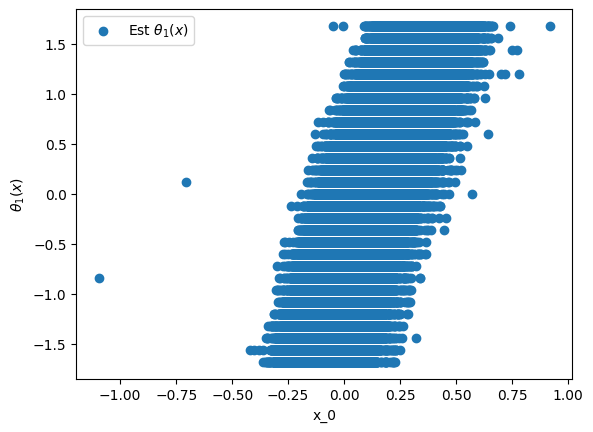

In [ ]:
ab = model_ab(x)
n = x.shape[0]
beta = ab[:,1].reshape(n,)
alpha = ab[:,0].reshape(n,)
print(torch.mean(beta))
print(torch.mean(alpha))
plt.scatter(beta.cpu().detach().numpy(), x[:,1].cpu().detach().numpy(), label = f'Est $\\theta_1(x)$')
plt.xlabel('x_0')
plt.ylabel(f'$\\theta_1(x)$')
plt.legend()
plt.show()